## Line Following with Obstacle Avoidance

The final task of this week is a combination of the line following, obstacle detection, and wall following behaviors.

The robot should follow the line until an obstacle is detected in its path. Then, the robot will turn left and follow the wall at its right until the line is detected again, and it will resume the line following behavior.

Please watch the following demo video:

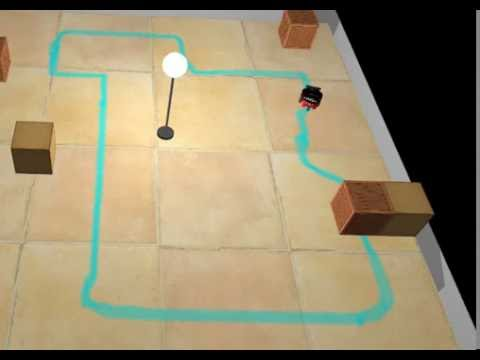

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Jd1jpt3pgc8')

This is the most complex task that we have programmed so far, thus it is a nice candidate for developing with the so-called [**top-down** approach](https://en.wikipedia.org/wiki/Top-down_and_bottom-up_design). With this methodology, we start with a high-level algorithm, and break it down into its components:

    repeat forever
        follow line until an obstacle is detected
        get close to the wall
        follow wall until a line is detected
        get close to the line

**IMPORTANT**: before running the code below, please restart the simulation in Webots.

### Initialization
First, we need to import all the required modules.

In [2]:
from Pioneer3.Controllers import PioneerRobot

robot = PioneerRobot()
import cv2
import numpy

### Component functions
The first function must return `True` if an obstacle is detected in front of the robot, or `False` otherwise.

In [3]:
def is_obstacle_detected():
    threshold = 0.5
    distance = robot.getSonar()
    if distance[3] < threshold or distance[4] < threshold or distance[0] < threshold:
        return True
    return False

The second function is the line following behavior as seen in previous notebooks during this week.

In [4]:
def follow_line():
    while not is_obstacle_detected():
        robot.kinect.setTiltPosition(-0.47) # tilt down the Kinect
        try:
            width = robot.kinect.getColorImage().shape[1]
            image = robot.kinect.getColorImage()
            cx, cy = line_centroid(image)
            err = cx - (width/2)
            linear = 0.1
            angular = -0.01 * err
            move(linear, angular)
        except KeyboardInterrupt:
            move(0,0)
    print('Obstacle detected')

The next function was developed in the previous week: the robot turns until it is approximately parallel to the wall.

In [5]:
MIN_WALL_THRESHOLD = 0.3
MAX_WALL_THRESHOLD = 0.4

DEF_X_SPEED = 0.2      
DEF_YAW_SPEED = 0.15    
def getWall():
    robot.kinect.setTiltPosition(-0.47)

    distance = robot.getSonar()
    leftSide, frontSide = getSonars(distance)
    # move forward until an obstacle is detected at the front
    while frontSide > MIN_WALL_THRESHOLD:       
        move(DEF_X_SPEED,0)
        distance = robot.getSonar()
        leftSide, frontSide = getSonars(distance)
        
    distance = robot.getSonar()
    leftSide, frontSide = getSonars(distance)
        
    # turn until the wall is detected by sonar 0
    while distance[0] > MAX_WALL_THRESHOLD:
        if frontSide < leftSide:
            yawSpeed = -DEF_YAW_SPEED * 3
        else:
            yawSpeed = -DEF_YAW_SPEED
        distance = robot.getSonar()
        move(0,yawSpeed)
        leftSide, frontSide = getSonars(distance)
    move(0,0)

The next function is checked during the wall following behavior: it must return `True` when the line is again detected, or `False` otherwise.

In [6]:
def is_line_detected():
        image = robot.kinect.getColorImage()
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_cyan = numpy.array([80, 100, 100])
        upper_cyan = numpy.array([100, 255, 255])
        mask = cv2.inRange(hsv, lower_cyan, upper_cyan)
        M = cv2.moments(mask)
        if M['m00'] == 0:
            return False
        return True


Next, we reuse the wall following behavior from previous week.

In [7]:
MIN_WALL_THRESHOLD = 0.2
MAX_WALL_THRESHOLD = 0.3

DEF_X_SPEED = 0.2      
DEF_YAW_SPEED = 0.15
def follow_wall():
    print('Following the wall')
    while not is_line_detected():
        distance = robot.getSonar()
        leftSide, frontSide = getSonars(distance)
        # by default, just move forward
        xSpeed = DEF_X_SPEED
        yawSpeed = DEF_YAW_SPEED
        # if we're getting too close to the wall with the front side...
        if frontSide < MIN_WALL_THRESHOLD :
            # go backward and turn right quickly (x4)
            xSpeed = -0.1
            yawSpeed = -DEF_YAW_SPEED * 4
        else:
            # if we're getting too close to the wall with the left side...
            if leftSide < MIN_WALL_THRESHOLD :
                # move slowly forward (x0.5) and turn right
                xSpeed  = DEF_X_SPEED * 0.5
                yawSpeed = -DEF_YAW_SPEED
            else:
                # if we're getting too far away from the wall with the left side...
                if leftSide > MAX_WALL_THRESHOLD :
                    # move slowly forward (x0.5) and turn left
                    xSpeed  = DEF_X_SPEED * 0.5
                    yawSpeed = DEF_YAW_SPEED
        # Move the robot
        move(xSpeed,yawSpeed)
    print('Line detected')

Finally, a function is needed for turning the robot slightly until it is approximately parallel to the line again.

In [8]:
def getLine():
       return

Some additional lower-level functions are required (guess which ones?).

You can define them in the next empty cell.

In [9]:
# Lower-level functions
def line_centroid(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_cyan = numpy.array([80, 100, 100])
    upper_cyan = numpy.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower_cyan, upper_cyan)
    M = cv2.moments(mask)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx, cy


def move(V_robot,w_robot):
    r = 0.1953 / 2
    L = 0.33
    w_r = (2 * V_robot + L * w_robot) / (2*r)
    w_l = (2 * V_robot - L * w_robot) / (2*r)
    robot.setSpeed(w_l, w_r)
    
    
def getSonars(distance):
    leftSide = min(distance[0:3])
    frontSide = min(distance[3:5])
    return leftSide, frontSide

### Main loop
The main loop looks very similar to the proposed algorithm:

In [ ]:
robot.kinect.setTiltPosition(-0.47)
try:
    while True:
        follow_line()
        getWall()
        follow_wall()
        getLine()
except KeyboardInterrupt:
    move(0,0)

entra en el follow line
Obstacle detected
1
Entro a getwall
2
Following the wall
Line detected
3
entra en el follow line
Obstacle detected
1
Entro a getwall
2
Following the wall
Line detected
3
entra en el follow line
Obstacle detected
1
Entro a getwall
2
Following the wall
Line detected
3
entra en el follow line
Obstacle detected
1
Entro a getwall
2
Following the wall
Line detected
3
entra en el follow line


Did it work? Congratulations, you have completed the task of this week!

---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>